In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np 
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape,LeakyReLU, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D,UpSampling2D, MaxPooling2D, Dense
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ab = np.load('/content/drive/My Drive/ab1.npy')
gray = np.load('/content/drive/My Drive/gray_scale.npy')

In [14]:
# preps/reshapes grayscale images
def batch_prep(gray_img, batch_size=100):
  #creates an array of zeros that a CNN accepts (batch size, height, width, depth (3 channels for RGB))
  img = np.zeros((batch_size, 224, 224, 3))
  # takes only the batch size of gray images and iterates through 3 channels (RGB) then appends to empty img array
  for i in range(0,3):
    img[:batch_size,:,:,i] = gray_img[:batch_size]
    return img
img_in = batch_prep(gray, batch_size=300)

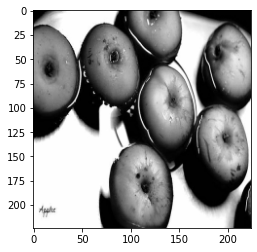

In [15]:
# displays gray images
plt.imshow(gray[29], cmap=plt.cm.gray)

In [16]:
# displays original data channels (batch size, height, width)
gray.shape

(25000, 224, 224)

In [17]:
# displays data channels post prep (batch size, height, width, depth (RGB))
img_in.shape

(300, 224, 224, 3)

In [18]:
# CNN model learns from grayscale and colored images

# preps colored images
# n represents batch size
def get_rbg(gray_imgs, ab_imgs, n=10):
  img1 = np.zeros((n, 224, 224, 3))
  # 0 and 1 denotes where we want to allocate the images
  img1[:,:,:,0] = gray_imgs[0:n:]
  img1[:,:,:,1:] = ab_imgs[0:n]
  # converts images to uint8 format to make it easier for cv2 library to process
  img1 = img1.astype("uint8")
  imgs = []
  for i in range(0, n):
    # converts images from LAB to RGB colorspace
    imgs.append(cv2.cvtColor(img1[i], cv2.COLOR_LAB2RGB))
  # converts images to numPy array
  imgs = np.array(imgs)
  return imgs

In [19]:
img_out = get_rbg(gray_imgs=gray, ab_imgs=ab, n=300)

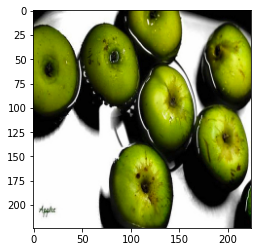

In [20]:
plt.imshow(img_out[29])

In [21]:
img_out.shape

(300, 224, 224, 3)

In [22]:
# Conv2d helps to convert data into tensors
# strides indicates how many pixels the filter shifts while going over the image 
# kernel_size is a matrix that specifies the size of the convolutional filter. Extracts RGB features from the image, hence why we use 3
# filters are a set of learnable weights that use the back propagation algorithm to learn these weights and are dependent on kernel size (must be in multiples of 3)
# bias is an additional set of weights that allow you to shift the activation function by adding a constant which helps model select best possible weights on its own
# padding set to valid indicates all the images are the same size, therefore, we don't need padding
# relu (rectified linear unit) transforms the summed weighted input from the node into the activation of the node
# Conv2dTranspose is an inverse Conv2d layer that upsamples inputs and fine tunes the weights
# LeakyReLU activation function fixes the dying ReLU problem (when inputs approach zero, or are negative, the gradient of the function becomes zero, the network cannot perform backpropagation and cannot learn) by adding a small gradient when the unit is not active
# Dropout layer randomly kills a percentage of neurons in a training in every training iteration. Prevents the model from overfitting

model = Sequential()
model.add(Conv2D(strides=(1, 1), kernel_size=3, filters=12, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=(1, 1), kernel_size=3, filters=12, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

model.add(Conv2D(strides=(1, 1), kernel_size=3, filters=12, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=(1, 1), kernel_size=3, filters=3, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

model.add(Conv2D(strides=(1, 1), kernel_size=3, filters=12, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=(1, 1), kernel_size=3, filters=3, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

# AveragePooling2D calculates the average for each patch of the feature map of the images in our input. Summarizes weights and ensures the best possible outputs at the cost of downsampling the inputs
# UpSampling2d layer doubles the dimensions of our input and helps to counter the downsampling from AveragePooling2D

model.add(Conv2D(strides=(1, 1), kernel_size=3, filters=12, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=(1, 1), kernel_size=3, filters=3, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(UpSampling2D((2, 2)))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

model.add(Conv2D(strides=(1, 1), kernel_size=3, filters=12, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=(1, 1), kernel_size=3, filters=3, use_bias=True, bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), padding="valid", activation=tf.nn.relu))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

In [23]:
# Adam optimizer is an adaptive learning rate algorithm used for optimization
# mape (mean absolute percentage error) measures the extent of the error in the form of a percentage and is ideal for regression problem
# clipvalue clips the derivatives of the loss function and prevents gradient explosion (increased loss from each epoch) from occuring as you increase the amount of epochs

# compiles the model for training
model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5), loss='mape', metrics=tf.keras.metrics.Accuracy())

In [24]:
# batch_size should always be 16 for CNN models

# trains the model
model.fit(img_in, img_out, epochs=10, batch_size=16)

Epoch 1/10
19/19 [==============================] - 35s 69ms/step - loss: 11522795.0750 - accuracy: 0.0451
Epoch 2/10
19/19 [==============================] - 1s 54ms/step - loss: 266646.2945 - accuracy: 0.0536
Epoch 3/10
19/19 [==============================] - 1s 53ms/step - loss: 2452.5556 - accuracy: 0.0754
Epoch 4/10
19/19 [==============================] - 1s 52ms/step - loss: 92.6950 - accuracy: 0.0740
Epoch 5/10
19/19 [==============================] - 1s 53ms/step - loss: 93.3397 - accuracy: 0.0667
Epoch 6/10
19/19 [==============================] - 1s 52ms/step - loss: 93.0888 - accuracy: 0.0691
Epoch 7/10
19/19 [==============================] - 1s 53ms/step - loss: 93.0133 - accuracy: 0.0699
Epoch 8/10
19/19 [==============================] - 1s 53ms/step - loss: 92.8936 - accuracy: 0.0711
Epoch 9/10
19/19 [==============================] - 1s 54ms/step - loss: 93.2783 - accuracy: 0.0672
Epoch 10/10
19/19 [==============================] - 1s 52ms/step - loss: 92.4998 - acc

In [25]:
# uses trained model to make a prediction on our grayscale images
prediction = model.predict(img_in)

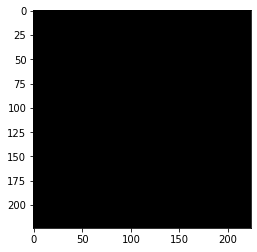

In [26]:
# displays the prediction for the selected image in our input
plt.imshow(prediction[29])

In [129]:
# loads model file trained for 5000 epochs
model2 = keras.models.load_model('modelfinal.h5')

In [130]:
prediction = model2.predict(img_in)

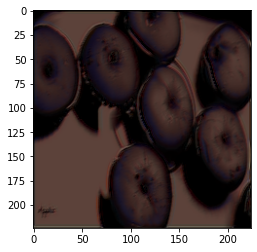

In [131]:
# uint8 prevents issues with updated version of matplotlib
plt.imshow(prediction[29].astype('uint8'))